In [38]:
# PROCESS THE OPEN CLUSTER CATAOLOG:
# https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/673/A114
#
#
# ZACK REEVES
# CREATED: 2023
#
# VERSIONS:
#  1.1  OCT 2023 CREATE JUPYTER NOTEBOOK

In [39]:
# Define the metadata for the data set. 
metadata = {}

metadata['project'] = 'Digital Universe Atlas'
metadata['sub_project'] = 'Open Clusters'

metadata['catalog'] = 'Improving the open cluster census. II. An all-sky cluster catalogue with Gaia DR3 (Hunt+, 2023)'
metadata['catalog_author'] = 'Hunt+'
metadata['prepared_by'] = 'Zack Reeves (AMNH)'
metadata['catalog_year'] = '2023' #Cade added this, not sure if this is what the catalog_year refers to
metadata['version'] = '1.1'

metadata['dir'] = metadata['sub_project'].replace(' ', '_').lower()
metadata['raw_data_dir'] = ''

metadata['data_group_title'] = 'Open Clusters'
metadata['data_group_desc'] = 'Open Cluster catalog'
metadata['fileroot'] = 'oc'

In [40]:
import pandas as pd
import numpy as np
import sys
import collections

from astropy.io import ascii
import astropy.units as u
import astropy.coordinates
from astropy.coordinates import Angle
from astropy.table import Table

from astroquery.vizier import Vizier

sys.path.insert(0, '..')
from common import file_functions, calculations

import matplotlib.pyplot as plt

In [41]:
#Reading in the catalog with Vizier
#We specify the row limit to make sure we get all the stars in the catalog
#We place constraints on the Parallax and Probability of being a White Dwarf as a preliminary thresh
#We specify columns = ['**'] to get all of the columns, not just the default ones
catalog = Vizier(catalog='J/A+A/673/A114/clusters', columns=['**'], row_limit=-1).query_constraints(dist50='> 0.0')
data = catalog[0]

In [42]:
data

recno,Name,ID,AllNames,Type,CST,N,CSTt,Nt,RA_ICRS,DE_ICRS,GLON,GLAT,r50,rc,rt,rtot,r50pc,rcpc,rtpc,rtotpc,pmRA,s_pmRA,e_pmRA,pmDE,s_pmDE,e_pmDE,Plx,s_Plx,e_Plx,dist16,dist50,dist84,Ndist,globalPlx,X,Y,Z,RV,s_RV,e_RV,n_RV,CMDCl2.5,CMDCl16,CMDCl50,CMDCl84,CMDCl97.5,CMDClHuman,logAge16,logAge50,logAge84,AV16,AV50,AV84,diffAV16,diffAV50,diffAV84,MOD16,MOD50,MOD84,minClSize,isMerged,isGMMMemb,NXmatches,XmatchType,_RA.icrs,_DE.icrs
,,,,,,,,,deg,deg,deg,deg,deg,deg,deg,deg,pc,pc,pc,pc,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,mas,mas,mas,pc,pc,pc,,,pc,pc,pc,km / s,km / s,km / s,,,,,,,,log(yr),log(yr),log(yr),mag,mag,mag,mag,mag,mag,mag,mag,mag,,,,,,deg,deg
int32,str20,int16,str246,str1,float64,int32,float64,int32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,uint8,float64,float64,float64,float64,float64,float64,int16,float32,float32,float64,float64,float64,str3,float64,float64,float64,float32,float64,float64,float32,float64,float64,float64,float64,float64,int16,uint8,uint8,int16,str3,float64,float64
1,1636-283,0,"1636-283,C1636-283,ESO_452-11,MWSC_2436",o,8.10614082,38,8.79495092,32,249.85574296,-28.39919379,351.91030597,12.1,0.01631940,0.00742385,0.12584063,0.22651419,1.72703758,0.78564634,13.31739299,23.97150627,-1.45490226,0.15886797,0.02808415,-6.52578330,0.17334299,0.03064300,0.13138146,0.04140242,0.00731898,5791.24202555,6063.45669451,6362.52422040,38,0,-2248.91644206,-834.32990523,1276.42855260,16.78638176,2.27406709,1.01699372,5,0.000378,0.00207,0.04005899,0.06837487,0.25756931,,8.02525997,8.48795652,8.89044094,2.66,3.09364164,3.48359799,0.914,1.47147715,1.94626451,13.77143288,14.00199080,14.18769836,20,0,0,2,1:m,249.85575031,-28.39916479
2,ADS_16795,1,"ADS_16795,AR_Cas",o,6.83219864,41,6.83219864,41,352.59216492,58.55341329,112.50889463,-2.67,2.65315906,3.25585879,8.48997672,8.48997672,9.56715258,11.74470786,30.81841428,30.81841428,18.65660390,1.30185671,0.20331586,2.84661253,1.25803641,0.19647228,4.75961052,0.10161330,0.01586933,206.28167669,206.45788462,206.63439385,32,0,-8200.94946741,190.52326760,11.39159669,-13.35774436,1.63019018,0.57635926,8,0.172,0.68,0.82842210,0.99782628,0.99885023,,7.38828087,7.75518608,8.01615334,3.4e-07,0.17429753,0.26427069,0.00758,0.47076963,0.69389004,6.49167442,6.64998174,6.81462669,40,0,0,1,1:1,352.59200598,58.55340064
3,AH03_J0748+26.9,2,"AH03_J0748+26.9,AH03_J0748-26.9,AH03_J0748_26.9,FSR_1315,MWSC_1347,MWSC_1348",o,11.58552411,68,11.78130859,66,117.15588690,-26.97267949,243.20021931,-0.628,0.03410633,0.02795489,0.14630377,0.18884691,2.36860928,1.94140513,10.16049478,13.11504695,-2.46548955,0.04241582,0.00522103,3.18503456,0.05193567,0.00639284,0.20935812,0.03312631,0.00407757,3919.58056456,3979.06488330,4040.38251600,68,0,-9916.03213687,-3551.44898508,-18.19460187,79.36052331,16.09866262,4.64728360,1,0.996,1,0.99993774,1.00000000,1.00000000,TP,7.84066010,8.06174040,8.30396652,0.766,1.03666890,1.23329210,0.649,1.07900274,1.45545292,13.32692337,13.52147055,13.70749378,10,0,0,2,1:m,117.15589920,-26.97269365
4,ASCC_5,3,"ASCC_5,MWSC_93",o,8.31642236,25,8.31642236,25,14.46908222,55.82917381,123.84274797,-7.03,0.05449062,0.04499025,0.23229151,0.23229151,1.65574640,1.36706904,7.05842277,7.05842277,-2.40663082,0.08267997,0.01653599,-1.91881768,0.09263841,0.01852768,0.53819722,0.03764309,0.00752862,1721.68750605,1740.98320690,1760.71632064,24,0,-9084.80322366,1435.13376878,-189.84723555,--,--,--,0,0.99,0.999,0.99965981,1.00000000,1.00000000,,6.96985722,7.32589102,7.54225826,0.893,1.17621279,1.39558959,0.18,0.72346848,1.06781185,11.04681301,11.21208572,11.37013721,10,0,0,1,1:1,14.46910126,55.82918234
5,ASCC_6,4,"ASCC_6,MWSC_141,Theia_2326",o,19.25857004,209,19.25857004,209,26.84215882,57.73860678,130.36368620,-4.32,0.14360169,0.08214515,0.86658699,0.86658699,3.76421798,2.15326025,22.71744990,22.71744990,-0.83414476,0.10924057,0.00755633,

In [43]:
#calculating distance in light years and parsecs
calculations.get_distance(data, dist='dist50', use='distance')

In [44]:
#calculating cartesian coordinates
calculations.get_cartesian(data, ra='RA_ICRS', dec='DE_ICRS')

In [45]:
#playing around with threshing on distance
data.remove_rows(np.where(data['dist_pc']>20000)[0])

<function matplotlib.pyplot.show(close=None, block=None)>

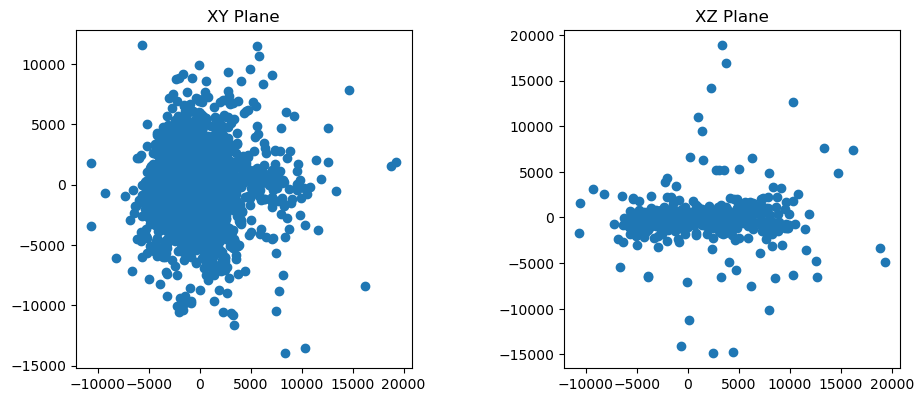

In [46]:
#2D Visualization
fig, ax = plt.subplots(1, 2)

#XY Plane
ax[0].scatter(data['x'], data['y'])
ax[0].set_title('XY Plane')

#XZ Plane
ax[1].scatter(data['x'], data['z'])
ax[1].set_title('XZ Plane')

#set good spacing
fig.tight_layout()
fig.set_size_inches(10, 4, forward=True)
plt.show

In [47]:
#construct a speck comment column
data['speck_label'] = data.Column(data=['#__'+name for name in data['Name']], 
                                  meta=collections.OrderedDict([('ucd', 'meta.id')]),
                                 description='Object ID')

#construct a label column
data['label'] = data['Name']  #leaving for now in case we want to add other labels

In [48]:
#construct a metadata table
columns = file_functions.get_metadata(data, columns=['x', 'y', 'z', 'dist_ly', 'N', 'r50', 'speck_label'])
columns

,name,unit,datatype,width,precision,arraysize,ucd,description
0,x,pc,float64,,6,,pos.cartesian.x,x position (galactic cartesian coordinates) in...
1,y,pc,float64,,6,,pos.cartesian.y,Position (y coordinate) in parsecs
2,z,pc,float64,,6,,pos.cartesian.z,Position (z coordinate) in parsecs
3,dist_ly,lyr,float64,,1,,pos.distance,Distance from Sun (lyr)
4,N,,int32,,,,NUMBER,[10/153797] Number of member stars
5,r50,deg,float64,11,8,,EXTENSION_RAD,Radius containing 50% of members within the ti...
6,speck_label,,str,,,*,meta.id,Object ID


In [49]:
# Print the speck file using the to_speck function in file_functions
file_functions.to_speck(metadata, Table.to_pandas(data), columns)

In [50]:
# Print the label file using the to_label function in file_functions
file_functions.to_label(metadata, Table.to_pandas(data))

In [51]:
file_functions.to_csv(metadata, Table.to_pandas(data), columns)